In [2]:
try:
  # This is a special Colab magic command to set TensorFlow version
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Download the dataset from FreeCodeCamp's project URL
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# Unzip the dataset archive
!unzip cats_and_dogs.zip

# Define base path and subdirectories for training, validation, and testing datasets
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Count the number of images in each folder for verification
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [33]:

# STEP 3: Image data generators for loading and preprocessing images
# These generators normalize pixel values (rescale=1./255)
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Load images from directories and apply preprocessing in real-time
# class_mode='binary' because we have 2 classes: cats and dogs
train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary')

val_data_gen   = validation_image_generator.flow_from_directory(
                    validation_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary')

# Load test images from subfolder named "test" under PATH
# shuffle=False to maintain original file order
test_data_gen  = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    classes=['test'],
                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


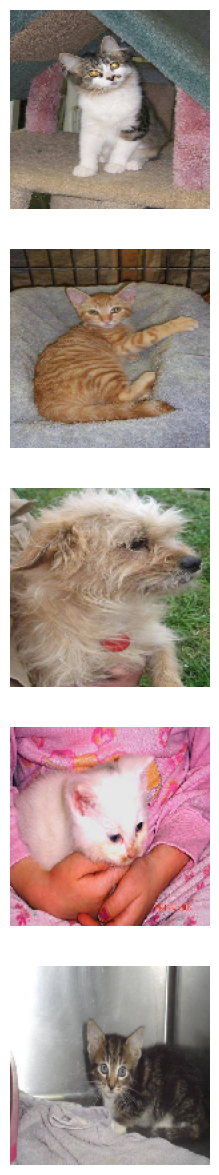

In [34]:
# STEP 4: Function to visualize a batch of images
# Optionally, shows predicted class probabilities as labels
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

# Visualize a few images from the training generator
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [35]:
# STEP 5: Update the training image generator to include data augmentation
# This introduces variation to the training data and helps prevent overfitting
train_image_generator = ImageDataGenerator(
                          rescale=1./255,
                          rotation_range=40,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          shear_range=0.2,
                          zoom_range=0.2,
                          horizontal_flip=True)


Found 2000 images belonging to 2 classes.


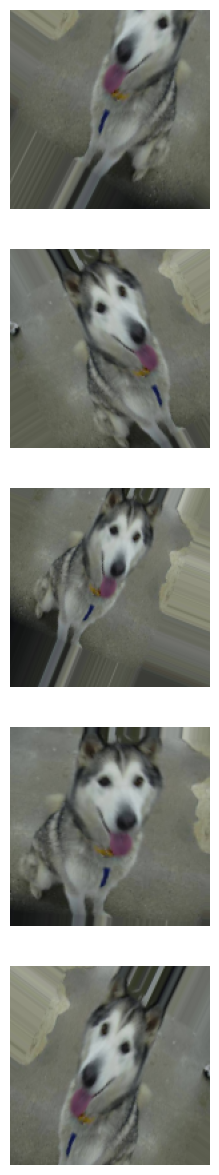

In [36]:
# STEP 6: Reload the training data generator with augmentation enabled

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

# Preview augmented training images
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [54]:
# STEP 7: Build the Convolutional Neural Network model
model = Sequential()

# First convolutional layer with 32 filters
model.add(Conv2D(32, (3, 3),activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(2, 2)) # Reduces spatial dimensions

# Second convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Third convolutional layer with 64 filters
model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten feature maps to feed into dense layers
model.add(Flatten())

# Dropout layer to help prevent overfitting by randomly dropping 50% of the neurons
model.add(Dropout(0.5))


# Dense hidden layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer with 1 unit and sigmoid activation (for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model using binary crossentropy loss (for binary labels)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │       4,735,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,791,425 (18.28 MB)

 Trainable params: 4,791,425 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# STEP 8: Train the model
# Training and validation performance will be tracked across epochs
history = model.fit(train_data_gen, validation_data=val_data_gen, epochs=epochs)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 945ms/step - accuracy: 0.7338 - loss: 0.5376 - val_accuracy: 0.7280 - val_loss: 0.5163
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 924ms/step - accuracy: 0.7396 - loss: 0.5246 - val_accuracy: 0.7400 - val_loss: 0.5125
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 928ms/step - accuracy: 0.7446 - loss: 0.5069 - val_accuracy: 0.7310 - val_loss: 0.5177
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 959ms/step - accuracy: 0.7333 - loss: 0.5139 - val_accuracy: 0.7420 - val_loss: 0.4892
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 919ms/step - accuracy: 0.7458 - loss: 0.5082 - val_accuracy: 0.7380 - val_loss: 0.5142
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 919ms/step - accuracy: 0.7602 - loss: 0.4947 - val_accuracy: 0.7520 - val_loss: 0.4965
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 920ms/step - accuracy: 0.7495 - loss: 0.4914 - val_accuracy: 0.7450 - val_loss: 0.5171
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 909ms/step - accuracy: 0.7463 - loss: 0.5080 - val_accu

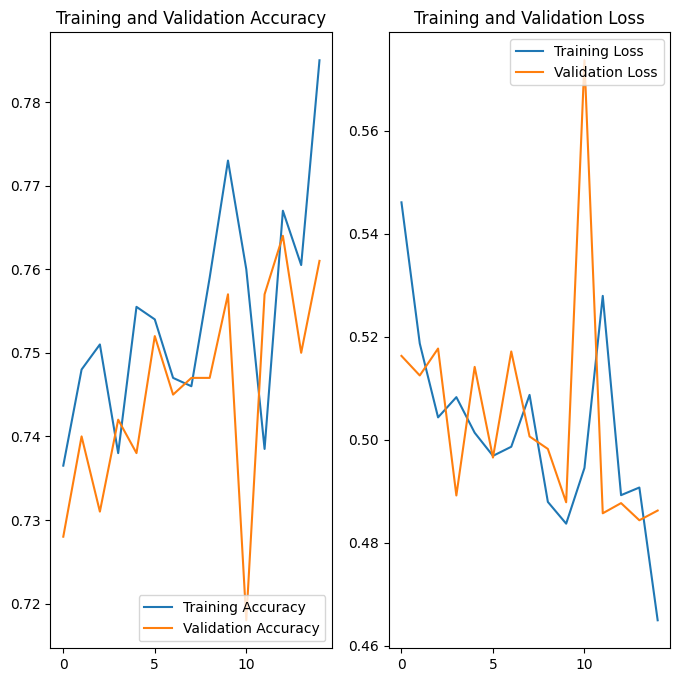

In [58]:
# STEP 9: Plot training history (accuracy and loss over epochs)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot accuracy and loss side-by-side
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

IntSlider(value=15, continuous_update=False, description='Epochs:', max=50, min=1)

Selected Epochs: 15


In [61]:
# STEP 10: Predict the test set
# This will give a probability between 0 and 1 for each test image
probabilities = model.predict(test_data_gen).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


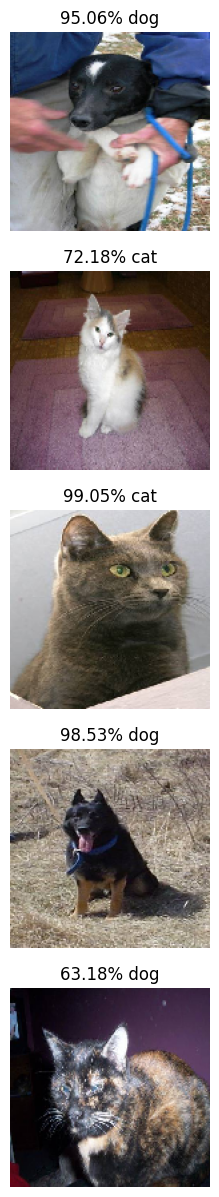

In [65]:
test_images, _ = next(test_data_gen)
plotImages(test_images[:5], probabilities=probabilities[:5])

In [62]:
# STEP 11: Evaluate predictions against the provided correct answers
# answers: Ground truth labels (1=dog, 0=cat)
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

# Count number of correct predictions
correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

# Calculate accuracy as a percentage
percentage_identified = (correct / len(answers)) * 100

# Challenge requirement: Must achieve at least 63% accuracy
passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 76.0% of the images of cats and dogs.
You passed the challenge!
